## Finding Donors for *CharityML* using Supervised Machine Learning

## About the Project

In this project, we will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid".
The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [16]:
# Total number of records
n_records = data['income'].count()

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income']=='>50K']['income'].count()

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income']=='<=50K']['income'].count()

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k*100)/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

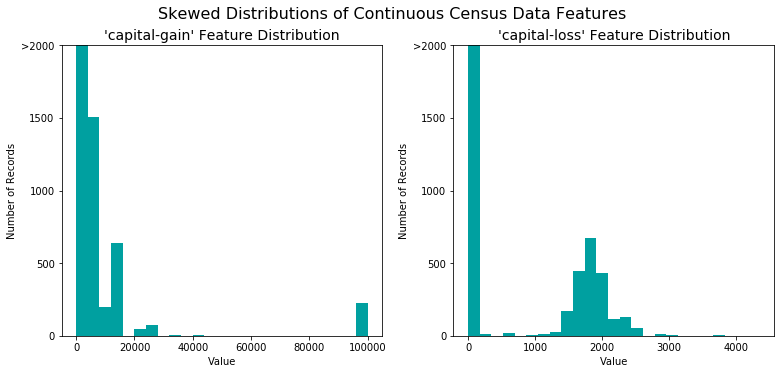

In [17]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

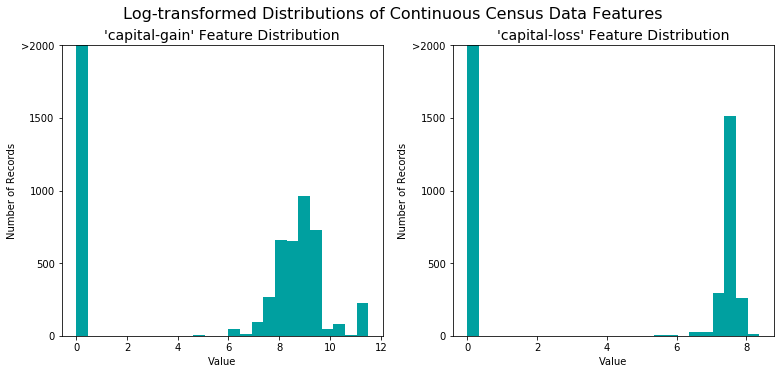

In [18]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [19]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [20]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x=='<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


103 total features after one-hot encoding.


In [22]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance


### Analyzing Naive Predictor Performace
Checking the model performance for an individual made more than $50,000 using model's accuracy and F-score

In [23]:
TP = np.sum(income) 
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = n_greater_50k/n_records
recall = float(TP)/TP+FN
precision = float(TP)/TP+FP

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
#Here 'b' describes the 'beta'
b = 0.5
fscore = ((1 + (b**2))*(accuracy*recall))/(((b**2)*accuracy) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### A few relevant supervised ML methods which could be useful for solving this problem are provided below:
- **Support Vector Machines (SVM)**
    SVM are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier 
    
     **- Application**: This method is used for the classificaton of images. This method is also used for the recognition of hand written characters.
     
     **- Strengths/Advantages:** This model is effective in high dimensional spaces and best suited for problems with complex domains where there are clear margins of separation in the data. To correctly classify the data, this model is also capable of defining complex higher order separation planes through custom kernels.
     
     **- Weaknesses:** They usually take a lot of training time as compared to other algorithms.In case of noisy data SVM's generally overfit and their performance is not good.
     
     **- Reason of Using this model:**Since we have not very much features this model can work very well for us.
     
     
- **Gaussian Naive Bayes**
    This method is used for the classification purposes.Naive Bayes is a classification algorithm for binary (two-class) and multi-class classification problems. The technique is easiest to understand when described using binary or categorical input values.The Naive Bayes algorithm is an intuitive method that uses the probabilities of each attribute belonging to each class to make a prediction. It is the supervised learning approach you would come up with if you wanted to model a predictive modeling problem probabilistically.
    
     **- Application**: It is widely used for classifying content/text in a document.
     
     **- Strengths/Advantages:** An advantage of naive Bayes is that it only requires a small number of training data to estimate the parameters necessary for classification.
     
     **- Weaknesses:** A disadvantage with Naive-Bayes is that if you have no occurrences of a class label and a certain attribute value together (e.g. class="nice", shape="sphere") then the frequency-based probability estimate will be zero. Given Naive-Bayes' conditional independence assumption, when all the probabilities are multiplied you will get zero and this will affect the posterior probability estimate.
     
     **- Reason of Using this model:**This model will be a good way to start as we have large dataset with very few features as compared to the data.
     
     
- **Gradient Boosting Classifier:**
    Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
    
     **- Application**: Gradient boosting can be used in the field of learning to rank. The commercial web search engines like Yahoo and Yandex use variants of gradient boosting in their machine-learned ranking engines.
     
     **- Strengths/Advantages:** The main strength of this classifier is that it build new trees along with already built trees which helps to correct the errors from already built trees.They take very less training time as compared to the other algorithms.
     
     **- Weaknesses:** Unconstrained, individual trees are prone to overfitting because they can keep branching until they memorize the training data. However, this can be alleviated by using ensembles.
     
     **- Reason of Using this model:** This model takes very less training time and can provide good results , So it is a good to choose this model.
     

**Refrences:**
- https://en.wikipedia.org/wiki/Support_vector_machine
- https://en.wikipedia.org/wiki/Naive_Bayes_classifier
- https://machinelearningmastery.com/naive-bayes-for-machine-learning/
- https://en.wikipedia.org/wiki/Gradient_boosting
 -https://elitedatascience.com/machine-learning-algorithms

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.

In [24]:
from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

/Users/maheshjindal/anaconda/envs/pythonapps/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


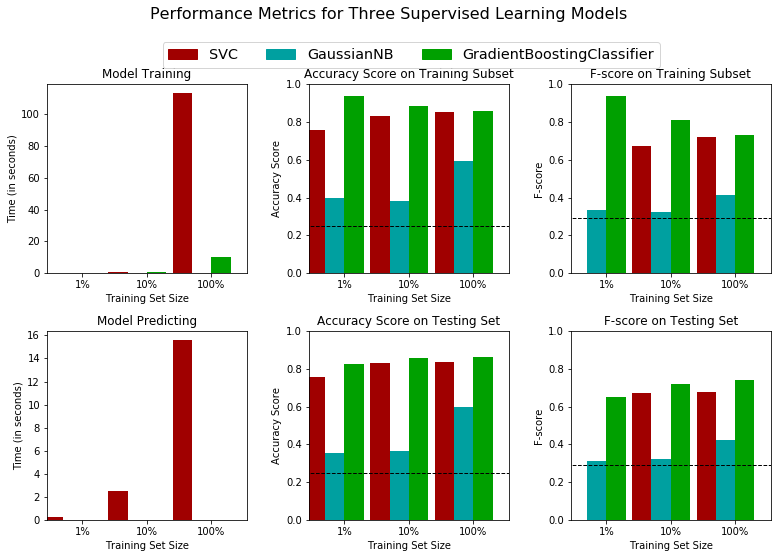

In [25]:
#  Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the three models
clf_A = SVC(random_state=20)
clf_B = GaussianNB()
clf_C = GradientBoostingClassifier(random_state=20)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(y_train))
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

###  Choosing the Best Model


- On the overall basis we can see that from the above 3 selected models **Gradient Boosting Classifier** is providing the best results in a more efficient manner.As we can see this model is providing very high accuracy and F-Score.This model is providing very good results on different test sizes. Also the accuracy score on the testing set is very good.

- As compared to the SVC (ie for SVM) this model is taking very less training and prediction time and providing very good results. 

- The Gradient Boosting Classifier produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.Also this algorithm is taking very less time for the prediction as compared to the other two models.So it is the wiser option to use this model.


### Explaining the model


Gradient Boosting Classifier is a Ensemble method.It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Gradient boosting combines weak "learners" into a single strong learner in an iterative fashion. It is easiest to explain in the least-squares regression setting, where the goal is to "teach" a model to predict values

This Classifier look at the data and categorize them into categories as it is built on top of decision trees.It involves three elements:
    - A loss function to be optimized
    - A weak learner to make predictions.
    - An additive model to add weak learners to minimize the loss function.

Loss function which measures the error in the predictions of the model.As it is differentiable it also gives a way to check a way that the error is decreasing or not.Specifically regression trees are used that output real values for splits and whose output can be added together, allowing subsequent models outputs to be added and “correct” the residuals in the predictions.Gradient descent is used to minimize a set of parameters, such as the coefficients in a regression equation or weights in a neural network. After calculating error or loss, the weights are updated to minimize that error.

Refrences:
 - https://en.wikipedia.org/wiki/Gradient_boosting
 - https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

### Model Tuning

In [26]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,fbeta_score
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=20)

# Create the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'loss': ['deviance', 'exponential'],
              'max_depth':[1,3,5,7]
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("running")
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

running
Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8697
Final F-score on the testing data: 0.7504


### Final Model Evaluation


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8630       |      0.8697     |
| F-score        |      0.7395       |      0.7504     |


- Optimized model accuracy score on the testing data: 0.8697
- Optimized model F-score on the testing data: 0.7504
- From the results, these scores are better than the original model.
- Hence the accuracy score is improved by nearly 0.78%
- Hence the F-score is improved by nearly by 1.47%

After the tuning as we can see that the results are improved on both training and testing set.So we can say that after optimizing our model will provide better results than the benchmarks found in Q1

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

According to me, the five features which i believe are the most important features, are described below:

 - **capital-gain:** The profit earned by a person depends upon the capital gain. So it is one of the major factor in the features.

 - **education_num:**The job of a person is somehow related to the education level of the person.So the person with the higher education level might have higher income.

 - **maritial-status:** As the married person spends much more than an unmarried person, So the net worth of a married person is usually less than an unmarried person.

 - **age:**This can be a one of the factors.As the persons with the more age are more experienced and hence they earn more.
 
 - **capital-loss** This factor provides the loss of an individual in the income. So it can be a factor for a person's net worth.


### Extracting Feature Importance

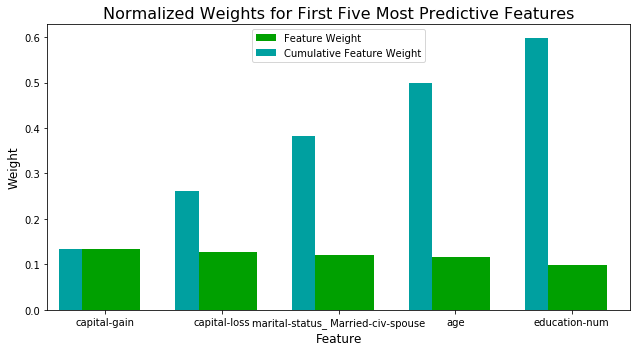

In [27]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
clf = GradientBoostingClassifier()
model = clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance


 As this above plot almost satisfies my thoughts. But the order has somehow changed. My thoughts somehow vary in the order
 
 I am satisfied with this fact somehow 'education-num' can be a more dominating factor than the capital-gain.(by seeing the plot). As higher educated people will earn more.
 
 I was thinking that capital-gain would affect the output a lot but in this case other factors are more dominating.
 
 I was also thinking that age could be a less dominating factor, but now by visualization i can say that age is quite a dominating factor for this problem.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [29]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8697
F-score on testing data: 0.7504

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7240


### Effects of Feature Selection


We can clearly see from the above that by reducing the data to only five features also reduces our accuracy on training and testing set.The output of our model also depends on the other features a lot because after reducing the features our accuracy is reduced by 1.14% which i think is a big number when we have a large dataset. So for this model other features are also the deciding factor.

If training time was a factor we can say that by reducing the number of features, the training time will definately be reduced.If we think on the basis of training time, then by reducing the no. of factors couldn't be a very big deal,as the error will slightly increase but effectively the training time will be reduced a lot.